In [1]:
# 01 - Imports & paths

import os
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt

# ML utils
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

# ALS (implicit feedback)
import implicit

# Item2Vec
from gensim.models import Word2Vec, KeyedVectors

# Sparse matrices
from scipy.sparse import coo_matrix

PROJECT_ROOT = Path("..").resolve()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PROCESSED:", DATA_PROCESSED)
print("MODELS_DIR:", MODELS_DIR)


c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PROJECT_ROOT: C:\Users\Kiera\Music_Recommender
DATA_PROCESSED: C:\Users\Kiera\Music_Recommender\data\processed
MODELS_DIR: C:\Users\Kiera\Music_Recommender\models


In [2]:
# 02 - Load combined features, metadata, and interactions; intersect on track_id

FEATURES_PATH      = DATA_PROCESSED / "combined_features.csv"
INTERACTIONS_PATH  = DATA_PROCESSED / "interactions.parquet"
TRACK_META_PATH    = DATA_PROCESSED / "track_metadata.csv"

# --- Load combined features ---
feat_df = pd.read_csv(FEATURES_PATH)
print("Features shape:", feat_df.shape)

# --- Load track metadata (for names, URIs, etc.) ---
meta_df = pd.read_csv(TRACK_META_PATH)
print("Track metadata shape:", meta_df.shape)

# --- Load interactions (pid, track_id, pos, duration_ms, ...) ---
inter_df = pd.read_parquet(INTERACTIONS_PATH)
print("Interactions shape:", inter_df.shape)

# Ensure track_id is string everywhere
for df_ in (feat_df, meta_df, inter_df):
    df_["track_id"] = df_["track_id"].astype(str)

# Keep only tracks that exist in all 3 (features + metadata + interactions)
track_ids_all = (
    set(feat_df["track_id"])
    & set(meta_df["track_id"])
    & set(inter_df["track_id"])
)

print("Tracks present in ALL (features+meta+interactions):", len(track_ids_all))

feat_df = feat_df[feat_df["track_id"].isin(track_ids_all)].reset_index(drop=True)
meta_df = meta_df[meta_df["track_id"].isin(track_ids_all)].reset_index(drop=True)
inter_df = inter_df[inter_df["track_id"].isin(track_ids_all)].reset_index(drop=True)

print("Filtered shapes:")
print("  features:", feat_df.shape)
print("  meta    :", meta_df.shape)
print("  inter   :", inter_df.shape)

# Simple metadata index for lookups (global)
meta_simple = (
    meta_df[["track_id", "track_name", "artist_name", "album_name"]]
    .drop_duplicates()
    .set_index("track_id")
)


Features shape: (4589288, 17)
Track metadata shape: (679889, 7)
Interactions shape: (6685101, 4)
Tracks present in ALL (features+meta+interactions): 514672
Filtered shapes:
  features: (514672, 17)
  meta    : (514672, 7)
  inter   : (6175813, 4)


In [3]:
# 03 - Build numeric feature matrix + cosine KNN index (ALL intersection)

# Choose numeric feature columns (everything except ids / non-numerics)
non_feature_cols = {"track_id", "explicit"}  # explicit often messy / non-numeric
feature_cols = [
    c for c in feat_df.columns
    if c not in non_feature_cols and np.issubdtype(feat_df[c].dtype, np.number)
]

print("Feature columns used ({}):".format(len(feature_cols)))
print(feature_cols)

# Impute NaNs with column means
feat_mat = feat_df[feature_cols].copy()
feat_mat = feat_mat.fillna(feat_mat.mean())

# Standardise then L2-normalise rows
scaler_all = StandardScaler()
X_scaled_all = scaler_all.fit_transform(feat_mat.values)

row_norms_all = np.linalg.norm(X_scaled_all, axis=1, keepdims=True)
row_norms_all[row_norms_all == 0.0] = 1.0
X_norm_all = X_scaled_all / row_norms_all

print("X_norm_all shape:", X_norm_all.shape)
print("Mean row norm (all):", float(np.linalg.norm(X_norm_all, axis=1).mean()))

# Track index mapping for feature space
track_ids_all_arr = feat_df["track_id"].values
tid_to_feat_idx_all = {tid: i for i, tid in enumerate(track_ids_all_arr)}

# Cosine KNN index (exact NN with brute-force cosine)
knn_cosine_all = NearestNeighbors(metric="cosine", algorithm="brute")
knn_cosine_all.fit(X_norm_all)

print("Built cosine KNN index on ALL intersection.")


Feature columns used (15):
['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'year', 'time_signature', 'popularity']
X_norm_all shape: (514672, 15)
Mean row norm (all): 1.0
Built cosine KNN index on ALL intersection.


In [4]:
# 04 - Load Item2Vec (Word2Vec) model

item2vec_path = MODELS_DIR / "item2vec_word2vec.model"

if not item2vec_path.exists():
    raise FileNotFoundError(f"Item2Vec model not found at: {item2vec_path}")

print("Loading Item2Vec model from:", item2vec_path)

# Load full Word2Vec model
item2vec_model = Word2Vec.load(str(item2vec_path))

# We'll use the keyed vectors as our "track embedding" lookup
item2vec_kv = item2vec_model.wv

print("Item2Vec vocab size:", len(item2vec_kv.key_to_index))


Loading Item2Vec model from: C:\Users\Kiera\Music_Recommender\models\item2vec_word2vec.model
Item2Vec vocab size: 306873


In [5]:
# 05 - Hybrid track universe: tracks with features + meta + interactions + item2vec

track_universe = (
    set(feat_df["track_id"])
    & set(meta_df["track_id"])
    & set(inter_df["track_id"])
    & set(item2vec_kv.key_to_index.keys())
)

print("Track universe size (features+meta+inter+item2vec):", len(track_universe))

# Filter all three to this smaller, fully-covered universe
feat_df_u = feat_df[feat_df["track_id"].isin(track_universe)].reset_index(drop=True)
meta_df_u = meta_df[meta_df["track_id"].isin(track_universe)].reset_index(drop=True)
inter_df_u = inter_df[inter_df["track_id"].isin(track_universe)].reset_index(drop=True)

print("Filtered shapes (HYBRID universe):")
print("  features:", feat_df_u.shape)
print("  meta    :", meta_df_u.shape)
print("  inter   :", inter_df_u.shape)

# Rebuild feature matrix + scaling + normalisation on this universe
feat_mat_u = feat_df_u[feature_cols].copy()
feat_mat_u = feat_mat_u.fillna(feat_mat_u.mean())

scaler_u = StandardScaler()
X_scaled_u = scaler_u.fit_transform(feat_mat_u.values)

row_norms_u = np.linalg.norm(X_scaled_u, axis=1, keepdims=True)
row_norms_u[row_norms_u == 0.0] = 1.0
X_norm_u = X_scaled_u / row_norms_u

track_ids_u = feat_df_u["track_id"].values
tid_to_feat_idx_u = {tid: i for i, tid in enumerate(track_ids_u)}

knn_cosine_u = NearestNeighbors(metric="cosine", algorithm="brute")
knn_cosine_u.fit(X_norm_u)

print("Unified cosine index built on HYBRID universe.")


Track universe size (features+meta+inter+item2vec): 244370
Filtered shapes (HYBRID universe):
  features: (244370, 17)
  meta    : (244370, 7)
  inter   : (5905511, 4)
Unified cosine index built on HYBRID universe.


In [6]:
# 06 - Build ALS user–item matrix on FULL MPD interactions (correct orientation)

from scipy.sparse import coo_matrix
import implicit

als_inter = inter_df.copy()  # use FULL MPD inter_df, not the restricted one

# Encode playlists and tracks as categorical indices
pid_codes = als_inter["pid"].astype("category")       # playlists = users
tid_codes = als_inter["track_id"].astype("category")  # tracks = items

als_inter["pid_idx"] = pid_codes.cat.codes
als_inter["tid_idx"] = tid_codes.cat.codes

n_users = als_inter["pid_idx"].nunique()
n_items = als_inter["tid_idx"].nunique()

print(f"ALS (FULL MPD, CORRECT): n_users={n_users}, n_items={n_items}")
print(f"Num interactions (nnz): {len(als_inter):,}")

# Build **users × items** matrix (this is what implicit expects)
alpha = 1.0  # confidence scaling
data = np.ones(len(als_inter), dtype=np.float32) * alpha

rows = als_inter["pid_idx"].values   # users
cols = als_inter["tid_idx"].values   # items

user_items = coo_matrix((data, (rows, cols)), shape=(n_users, n_items)).tocsr()
print("user_items shape:", user_items.shape)

# Map ALS internal item index -> track_id
idx_to_tid_als = np.array(tid_codes.cat.categories)

als_model = implicit.als.AlternatingLeastSquares(
    factors=64,
    regularization=0.01,
    iterations=10,
    random_state=42,
)

print("Fitting ALS on user_items (users × items)...")
als_model.fit(user_items)   # <-- NO .T now
print("ALS training done.")

n_items_als = als_model.item_factors.shape[0]
print("ALS item_factors items:", n_items_als)

# Sanity checks – these should now pass with 514,672
assert n_items_als == n_items == len(idx_to_tid_als)

# Build clean mapping: track_id -> ALS item index
tid_to_item_idx_als = {tid: i for i, tid in enumerate(idx_to_tid_als)}
print("Example ALS item mapping:", list(tid_to_item_idx_als.items())[:3])


ALS (FULL MPD, CORRECT): n_users=100000, n_items=514672
Num interactions (nnz): 6,175,813
user_items shape: (100000, 514672)


c:\Users\Kiera\Music_Recommender\.venv\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


Fitting ALS on user_items (users × items)...


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


ALS training done.
ALS item_factors items: 514672
Example ALS item mapping: [('0000uJA4xCdxThagdLkkLR', 0), ('00039MgrmLoIzSpuYKurn9', 1), ('0005w1bMJ7QAMl6DY98oxa', 2)]


In [7]:
# 07 - Cluster HYBRID-universe tracks in audio-feature space

N_CLUSTERS = 20

print(f"Clustering tracks with KMeans (K={N_CLUSTERS})...")
kmeans_tracks = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    n_init="auto",
)
track_cluster_labels = kmeans_tracks.fit_predict(X_norm_u)
print("Track clustering complete.")

# Store cluster labels in a DataFrame for convenience
track_cluster_df = pd.DataFrame({
    "track_id": track_ids_u,
    "cluster_id": track_cluster_labels,
}).set_index("track_id")


Clustering tracks with KMeans (K=20)...
Track clustering complete.


In [8]:
# 08 - Helper functions: describe_tracks, search_tracks_by_name, get_cluster_id

def describe_tracks(track_ids, extra_cols=None, top_n=10):
    """
    Return metadata (and optional audio features) for given track_ids.
    Uses HYBRID-universe metadata and features.
    """
    track_ids = list(track_ids)

    # --- metadata ---
    meta_sub = (
        meta_df_u[["track_id", "track_name", "artist_name", "album_name"]]
        .drop_duplicates()
        .set_index("track_id")
        .loc[lambda df: df.index.intersection(track_ids)]
        .reset_index()
    )

    # --- optional audio features ---
    if extra_cols:
        feat_idx = feat_df_u.set_index("track_id")
        common_ids = feat_idx.index.intersection(track_ids)
        feat_sub = feat_idx.loc[common_ids, extra_cols].reset_index()
        meta_sub = meta_sub.merge(feat_sub, on="track_id", how="left")

    if top_n is not None:
        meta_sub = meta_sub.head(top_n)

    return meta_sub


def search_tracks_by_name(query, max_results=10):
    """
    Simple case-insensitive substring search over track_name in HYBRID universe.
    """
    q = query.lower()
    hits = (
        meta_df_u
        .loc[meta_df_u["track_name"].str.lower().str.contains(q, na=False),
             ["track_id", "track_name", "artist_name", "album_name"]]
        .drop_duplicates()
        .head(max_results)
    )
    return hits


def get_cluster_id(track_id):
    """
    Return cluster_id for a track_id, or None if not clustered.
    """
    try:
        return int(track_cluster_df.loc[track_id, "cluster_id"])
    except KeyError:
        return None


In [9]:
# 09 - Hybrid config: neighbour counts & candidate pool

# How many neighbours we ask from each individual model
COS_TOPN   = 1000   # cosine neighbours in feature space
ALS_TOPN   = 1000   # ALS similar items
I2V_TOPN   = 1000   # item2vec neighbours

# Cap on the final union of candidates before scoring
HYBRID_CANDIDATE_POOL = 2000


In [10]:
# 10 - Single-model scorers: cosine, ALS, item2vec


def cosine_scores_for_track(track_id, top_n=COS_TOPN):
    """
    Get cosine-similar tracks in feature space for a given track_id.
    Returns a DataFrame: [track_id, cosine_sim]
    """
    if track_id not in tid_to_feat_idx_u:
        return pd.DataFrame(columns=["track_id", "cosine_sim"])
    
    idx = tid_to_feat_idx_u[track_id]
    vec = X_norm_u[idx : idx + 1]

    # +1 to include the seed; we'll drop it
    distances, indices = knn_cosine_u.kneighbors(vec, n_neighbors=top_n + 1)
    distances = distances[0]
    indices = indices[0]

    sims = 1.0 - distances  # cosine similarity

    neigh_tids = track_ids_u[indices]

    df = pd.DataFrame({
        "track_id": neigh_tids,
        "cosine_sim": sims,
    })
    # drop self
    df = df[df["track_id"] != track_id].reset_index(drop=True)
    return df


def als_scores_for_track(track_id, top_n=ALS_TOPN):
    """
    Get ALS similar-item scores for a given track_id.
    Returns: [track_id, als_sim]
    """
    if track_id not in tid_to_item_idx_als:
        # This track has no ALS item factors
        return pd.DataFrame(columns=["track_id", "als_sim"])

    item_idx = tid_to_item_idx_als[track_id]
    n_items_als = als_model.item_factors.shape[0]
    if not (0 <= item_idx < n_items_als):
        # out of range for some reason -> treat as no ALS signal
        return pd.DataFrame(columns=["track_id", "als_sim"])

    sim_items, sim_scores = als_model.similar_items(
        itemid=item_idx,
        N=top_n + 1,   # include self
    )

    neigh_tids = idx_to_tid_als[sim_items]

    df = pd.DataFrame({
        "track_id": neigh_tids,
        "als_sim": sim_scores,
    })

    # Drop the seed track itself
    df = df[df["track_id"] != track_id].reset_index(drop=True)

    return df.head(top_n)


def item2vec_scores_for_track(track_id, top_n=I2V_TOPN):
    """
    Get item2vec neighbours for a given track_id.
    Returns: [track_id, item2vec_sim]
    """
    if track_id not in item2vec_kv:
        return pd.DataFrame(columns=["track_id", "item2vec_sim"])
    
    most_sim = item2vec_kv.most_similar(track_id, topn=top_n + 1)

    neigh_tids = []
    neigh_scores = []
    for tid, score in most_sim:
        if tid == track_id:
            continue
        neigh_tids.append(tid)
        neigh_scores.append(score)
        if len(neigh_tids) >= top_n:
            break

    df = pd.DataFrame({
        "track_id": neigh_tids,
        "item2vec_sim": neigh_scores,
    })
    return df


In [ ]:
# 11

def hybrid_scores_for_track(
    track_id: str,
    w_cos: float = 0.3,
    w_als: float = 0.3,
    w_i2v: float = 0.3,
    w_cluster: float = 0.1,
    top_k: int = 30,
    candidate_pool: int = 2000,
    debug_coverage: bool = True,
    verbose: bool | None = None,  # <--- added
) -> pd.DataFrame:
    """
    Compute hybrid scores for neighbours of a single seed track.

    Returns a dataframe with:
      track_id, cosine_sim, als_sim, item2vec_sim, same_cluster, hybrid_score
    """

    # if caller passes `verbose`, let it override debug_coverage
    if verbose is not None:
        debug_coverage = verbose

    # --- 1) Get candidates from each model (each up to candidate_pool) ---
    df_cos = cosine_scores_for_track(track_id, top_n=candidate_pool)
    df_als = als_scores_for_track(track_id, top_n=candidate_pool)
    df_i2v = item2vec_scores_for_track(track_id, top_n=candidate_pool)

    # --- 2) Outer-merge on track_id to get the union of all candidates ---
    df = df_cos.merge(df_als, on="track_id", how="outer")
    df = df.merge(df_i2v, on="track_id", how="outer")

    if df.empty:
        return df

    # Ensure numeric + fill missing scores with 0 (meaning 'no signal')
    for col in ["cosine_sim", "als_sim", "item2vec_sim"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        else:
       	    df[col] = np.nan

        df[col] = df[col].fillna(0.0)

    # --- 3) Optional debug: coverage per source in the candidate union ---
    if debug_coverage:
        n_cand = len(df)
        cov_cos = (df["cosine_sim"]   > 0).mean() * 100
        cov_als = (df["als_sim"]      > 0).mean() * 100
        cov_i2v = (df["item2vec_sim"] > 0).mean() * 100
        print(
            f"[COVERAGE] seed={track_id}, candidates={n_cand}, "
            f"cosine={cov_cos:.1f}%, ALS={cov_als:.1f}%, item2vec={cov_i2v:.1f}%"
        )

    # --- 4) Same-cluster bonus ---
    seed_cluster = get_cluster_id(track_id)
    df["same_cluster"] = df["track_id"].apply(
        lambda tid: 1.0 if (seed_cluster is not None and get_cluster_id(tid) == seed_cluster) else 0.0
    )

    # --- 5) Normalise each similarity column to [0,1] within this candidate set ---
    def _norm(col: str) -> pd.Series:
        vals = df[col].values
        max_val = np.max(vals)
        if max_val <= 0:
            # no positive signal for this source → all zeros
            return pd.Series(np.zeros_like(vals, dtype=np.float32), index=df.index)
        return pd.Series((vals / max_val).astype(np.float32), index=df.index)

    df["cosine_norm"]   = _norm("cosine_sim")
    df["als_norm"]      = _norm("als_sim")
    df["item2vec_norm"] = _norm("item2vec_sim")

    # --- 6) DON'T require all signals; just require any signal at all ---
    has_any_signal = (
        (df["cosine_norm"]   > 0)
        | (df["als_norm"]    > 0)
        | (df["item2vec_norm"] > 0)
    )
    df = df[has_any_signal]

    if df.empty:
        return df

    # --- 7) Hybrid score using the normalised signals + cluster bonus ---
    df["hybrid_score"] = (
        w_cos     * df["cosine_norm"]
        + w_als   * df["als_norm"]
        + w_i2v   * df["item2vec_norm"]
        + w_cluster * df["same_cluster"]
    )

    # --- 8) Drop the seed itself, sort, and take top_k ---
    df = df[df["track_id"] != track_id]
    df = df.sort_values("hybrid_score", ascending=False).head(top_k).reset_index(drop=True)

    return df


In [19]:
# 12 - User-facing helper: recommend_by_name_hybrid + demo examples


def recommend_by_name_hybrid(
    query,
    candidate_index=0,
    w_cos=0.3,
    w_als=0.3,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=20,
    candidate_pool=HYBRID_CANDIDATE_POOL,
):
    """
    Convenience wrapper:
      - fuzzy search by track_name within HYBRID universe
      - pick one candidate by index
      - compute hybrid recommendations
      - attach metadata + audio features
    """

    # --- 1. search ---
    hits = search_tracks_by_name(query, max_results=10)
    if hits.empty:
        print(f"No matches for query '{query}'")
        return None, pd.DataFrame()

    print("Search results:")
    display(hits.reset_index(drop=True))

    if candidate_index >= len(hits):
        raise ValueError(f"candidate_index {candidate_index} out of range for {len(hits)} results")

    seed_row = hits.iloc[candidate_index]
    seed_tid = seed_row["track_id"]

    print("\nChosen seed track:")
    display(seed_row.to_frame().T)

    # --- 2. hybrid scores ---
    df_scores = hybrid_scores_for_track(
        seed_tid,
        w_cos=w_cos,
        w_als=w_als,
        w_i2v=w_i2v,
        w_cluster=w_cluster,
        top_k=top_k,
        candidate_pool=candidate_pool,
        verbose=True,
    )

    if df_scores.empty:
        print("No hybrid candidates found.")
        return seed_row, df_scores

    # --- 3. attach metadata + a few audio features ---
    rec_df = describe_tracks(
        df_scores["track_id"].tolist(),
        extra_cols=["danceability", "energy", "valence", "tempo"],
        top_n=None,
    )

    rec_df = rec_df.merge(df_scores, on="track_id", how="left")
    rec_df = rec_df.sort_values("hybrid_score", ascending=False).reset_index(drop=True)

    print("\nHybrid recommendations:")
    display(rec_df.head(top_k))

    return seed_row, rec_df


# --- Demo examples for 5 seed songs ---

# Example 1: Pitbull "Hotel Room Service"
seed1, recs1 = recommend_by_name_hybrid(
    "hotel room service",
    candidate_index=0,
    w_cos=0.2,
    w_als=0.4,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 2: Billie Eilish "ocean eyes"
seed2, recs2 = recommend_by_name_hybrid(
    "ocean eyes",
    candidate_index=1,  # original track on dont smile at me (adjust if needed)
    w_cos=0.2,
    w_als=0.4,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 3: Travis Scott "90210"
seed3, recs3 = recommend_by_name_hybrid(
    "90210",
    candidate_index=5,  # Travis Scott "90210" (adjust if search order changes)
    w_cos=0.25,
    w_als=0.35,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 4: Beatles "Yesterday - Remastered"
seed4, recs4 = recommend_by_name_hybrid(
    "yesterday - remastered",
    candidate_index=0,
    w_cos=0.25,
    w_als=0.35,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)

# Example 5: Kanye West "Gold Digger"
seed5, recs5 = recommend_by_name_hybrid(
    "gold digger",
    candidate_index=3,  # Kanye "Gold Digger" (adjust if search order changes)
    w_cos=0.2,
    w_als=0.4,
    w_i2v=0.3,
    w_cluster=0.1,
    top_k=15,
)


Search results:


,track_id,track_name,artist_name,album_name
0,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution
1,4lxE7lFNmTmL7SVGAzxDnw,Hotel Room Service Remix,Pitbull,Pitbull Starring In Rebelution



Chosen seed track:


,track_id,track_name,artist_name,album_name
12597,0OPyDgTRuIdCJ9B4bYSths,Hotel Room Service,Pitbull,Pitbull Starring In Rebelution


TypeError: hybrid_scores_for_track() got an unexpected keyword argument 'verbose'

In [13]:
# 13 - PCA on a sample of tracks for 2D visualisation

N_SAMPLE = 20000
rng = np.random.default_rng(42)

idx_sample = rng.choice(X_norm_u.shape[0], size=min(N_SAMPLE, X_norm_u.shape[0]), replace=False)
X_sample = X_norm_u[idx_sample]
tids_sample = track_ids_u[idx_sample]
clusters_sample = track_cluster_labels[idx_sample]

pca = PCA(n_components=2, random_state=42)
X_pca_sample = pca.fit_transform(X_sample)

pca_df = pd.DataFrame({
    "x": X_pca_sample[:, 0],
    "y": X_pca_sample[:, 1],
    "track_id": tids_sample,
    "cluster_id": clusters_sample,
}).set_index("track_id")

print("PCA sample shape:", pca_df.shape)


PCA sample shape: (20000, 3)


Seed + recs not found in PCA sample (downsampling issue).


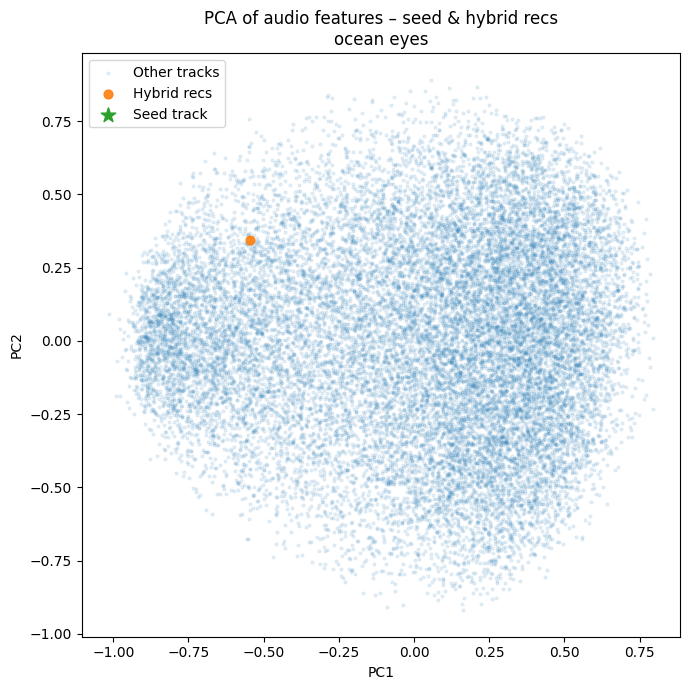

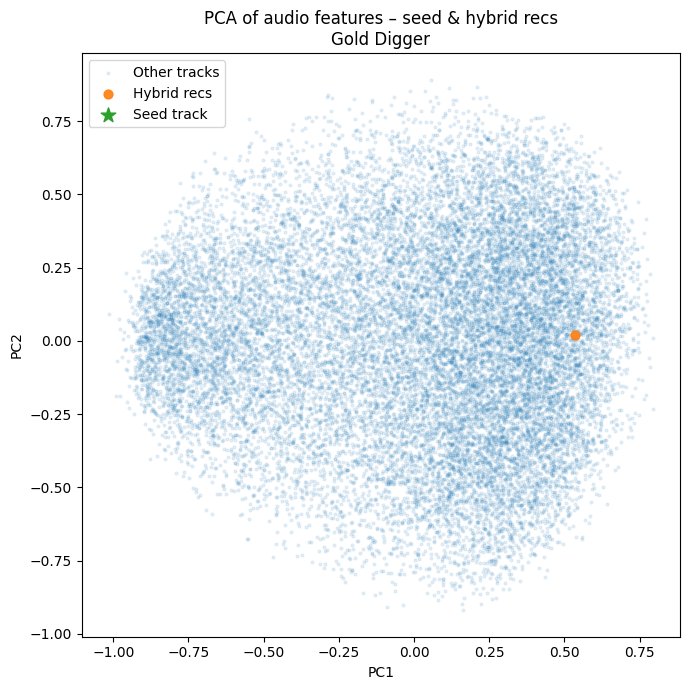

In [14]:
# 14 - Visual helper: plot seed + hybrid recommendations in PCA space

def plot_seed_and_recs_on_pca(seed_row, rec_df, title_suffix=""):
    seed_tid = seed_row["track_id"]

    rec_ids = rec_df["track_id"].tolist()
    all_ids = [seed_tid] + rec_ids

    df = pca_df.loc[pca_df.index.intersection(all_ids)].copy()
    if df.empty:
        print("Seed + recs not found in PCA sample (downsampling issue).")
        return

    df["is_seed"] = (df.index == seed_tid)

    plt.figure(figsize=(7, 7))

    # Background: all sampled tracks (faint)
    plt.scatter(
        pca_df["x"],
        pca_df["y"],
        s=4,
        alpha=0.1,
        label="Other tracks",
    )

    # Recommendations
    rec_mask = ~df["is_seed"]
    plt.scatter(
        df.loc[rec_mask, "x"],
        df.loc[rec_mask, "y"],
        s=40,
        alpha=0.9,
        label="Hybrid recs",
    )

    # Seed
    plt.scatter(
        df.loc[df["is_seed"], "x"],
        df.loc[df["is_seed"], "y"],
        s=120,
        marker="*",
        label="Seed track",
    )

    plt.title(f"PCA of audio features – seed & hybrid recs\n{title_suffix}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Example visualisations
if seed1 is not None and not recs1.empty:
    plot_seed_and_recs_on_pca(seed1, recs1, title_suffix=seed1["track_name"])
if seed2 is not None and not recs2.empty:
    plot_seed_and_recs_on_pca(seed2, recs2, title_suffix=seed2["track_name"])
if seed5 is not None and not recs5.empty:
    plot_seed_and_recs_on_pca(seed5, recs5, title_suffix=seed5["track_name"])


In [15]:
for tid, name in [
    ("0OPyDgTRuIdCJ9B4bYSths", "Hotel Room Service"),
    ("3OMh7VdOoWgtKhJimQQywz", "ocean eyes"),
    ("51EC3I1nQXpec4gDk0mQyP", "90210 (Travis Scott)"),
    ("5XJJdNPkwmbUwE79gv0NxK", "Gold Digger"),
    ("1e0hllQ23AG0QGFgezgLOq", "Yesterday"),
]:
    in_als = tid in tid_to_item_idx_als  # or the current ALS mapping name
    n_playlists = inter_df_u.loc[inter_df_u["track_id"] == tid, "pid"].nunique()
    print(name, tid, "in_als?", in_als, "playlists:", n_playlists)


Hotel Room Service 0OPyDgTRuIdCJ9B4bYSths in_als? True playlists: 329
ocean eyes 3OMh7VdOoWgtKhJimQQywz in_als? True playlists: 240
90210 (Travis Scott) 51EC3I1nQXpec4gDk0mQyP in_als? True playlists: 248
Gold Digger 5XJJdNPkwmbUwE79gv0NxK in_als? True playlists: 2987
Yesterday 1e0hllQ23AG0QGFgezgLOq in_als? True playlists: 313
